# Cryptocurrency Price Prediction with AUTO TS

>Development of a model to predict Bitcoin prices with machine learning using AUTO TS. The data was splited into train and test (considering 90:10 ratio) and evaluated by MAPE (Mean Absolute Percentage Error). To simplify the model, was considered historical prices from YFinance since 2021, January.
Source: https://finance.yahoo.com/

**Disclaimer:**
This Cryptocurrency Prediction Model can only work in situations where prices changes due to historical variation. Any other price variation reasons, such as government regulations, changes in financial policies, etc do not impact the presented predictions.

In [11]:
# Import modules:
import pandas as pd
import mplfinance as mpf
from IPython.utils import io
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Colect and process Bitcoin prices data from yfinance API:

In [12]:
# Getting data from file cryptocurrency_get_data.py:
exec(open('cryptocurrency_get_data.py').read())

There are 0 missing values on Data frame
Data frame shape: (805, 6)
Data frame extraction from 2021-01-01 to 2023-03-17
cryptocurrency_get_data successfully run


#### Candlestick chart to visualize Bitcoin Prices and the Simple Moving Average since 2022, July:

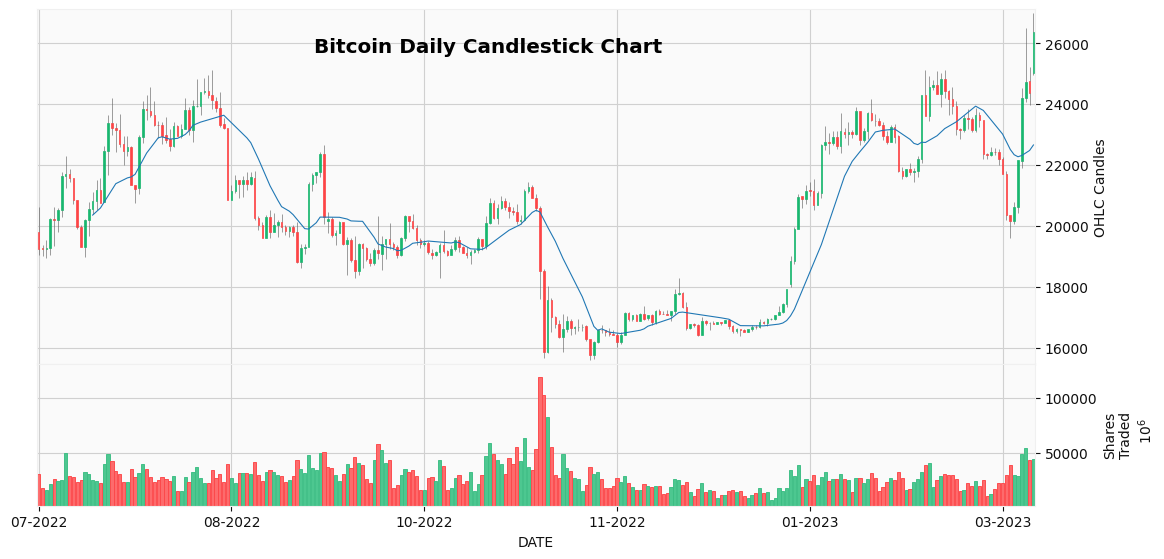

In [13]:
# Selecting and preparing data:
df_chart1 = df_btc.set_index('date')
df_chart1 = df_chart1.loc['2022-07-01':'2023-03-17',:]

# Creating Candlestick chart:
mpf.plot(df_chart1, type='candle', mav=(15), volume=True, style='yahoo',
         figratio=(20,10),datetime_format='%m-%Y',
         xrotation=0,tight_layout=True,title='Bitcoin Daily Candlestick Chart',
         ylabel='OHLC Candles',
         ylabel_lower='Shares\nTraded',
         xlabel='DATE')

The blue line represents Simple Moving Average from last 15 days.

### Model Building using AUTO TS:

In [17]:
# Building the model predict from file cryptocurrency_model_building.py:
with io.capture_output() as captured:
    exec(open('cryptocurrency_model_building.py').read())

####  Line chart to visualize train-test dataset:

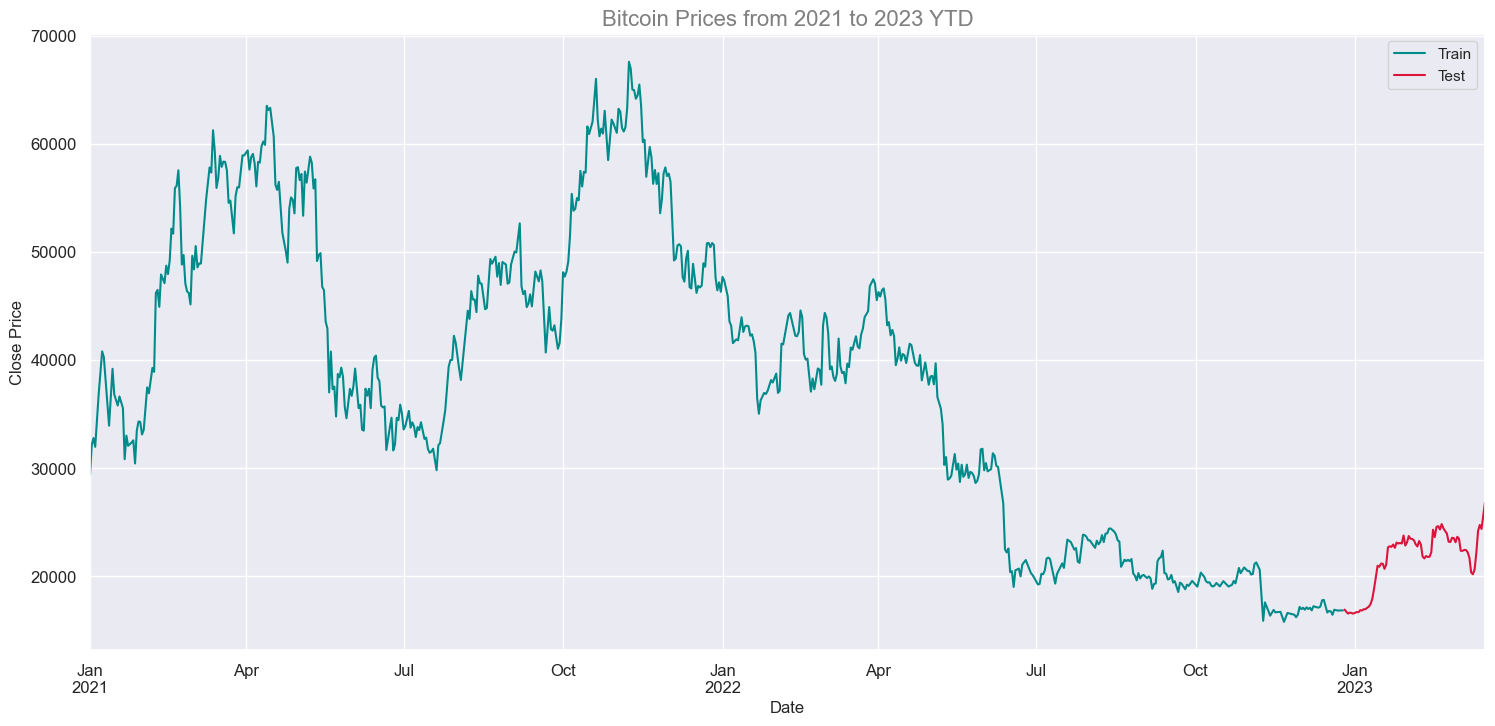

In [18]:
train_graph = train.set_index('date')
test_graph = test.set_index('date')

sns.set_theme()
train_graph.close.plot( figsize=(18,8), fontsize=12, label='Train', color='DarkCyan')
test_graph.close.plot(figsize=(18,8), fontsize=12, label='Test', color='Crimson')
plt.legend()
plt.title("Bitcoin Prices from 2021 to 2023 YTD", fontsize=16, color='Grey')
plt.xlabel("Date")
plt.ylabel("Close Price")

plt.show()

In [19]:
# Showing prediction:
prediction = model.predict()
forecast = prediction.forecast
print("Bitcoin Price Prediction")
print(forecast)

Bitcoin Price Prediction
                                  close
2022-12-26 00:00:00+00:00  16356.311631
2022-12-27 00:00:00+00:00  16318.972310
2022-12-28 00:00:00+00:00  16281.657195
2022-12-29 00:00:00+00:00  16244.366309
2022-12-30 00:00:00+00:00  16207.099677
...                                 ...
2023-03-12 00:00:00+00:00  13589.282555
2023-03-13 00:00:00+00:00  13553.856079
2023-03-14 00:00:00+00:00  13518.455835
2023-03-15 00:00:00+00:00  13483.081851
2023-03-16 00:00:00+00:00  13447.734159

[81 rows x 1 columns]


### Model Evaluation:

In [20]:
# Getting model results:
model_results = model.results()
model_results[['Model','Score']].sort_values('Score')

,Model,Score
1265,Ensemble,17.241259
1261,Ensemble,17.369448
1267,Ensemble,17.455293
1268,Ensemble,17.516488
1140,MetricMotif,17.993677
...,...,...
1247,UnobservedComponents,NaN
1487,AverageValueNaive,NaN
1554,ConstantNaive,NaN
1622,DatepartRegression,NaN


In [1]:
# compare the accuracy of different models : 
#model.get_leaderboard()
#model.plot_cv_scores()

In [22]:
# Checking best model name:
model.best_model_name

'AverageValueNaive'

Verificando o percentual de erro do modelo:

In [23]:
# Checking the percentage of errors:
y_true = test.close
y_pred = forecast.close

In [24]:
# Lets verify the Mean Absolute Percentage Error (MAPE) for the model:
# A low MAPE value means that the forcast are close to the results, in other hands a high value indicate that the model needs improvement.

mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE: {:.2f}%".format(mape*100))


MAPE: 29.21%


## The model achieved 29.21% of mean absolute percentage error (MAPE). 

### Lets see the model result of predictions in a chart:

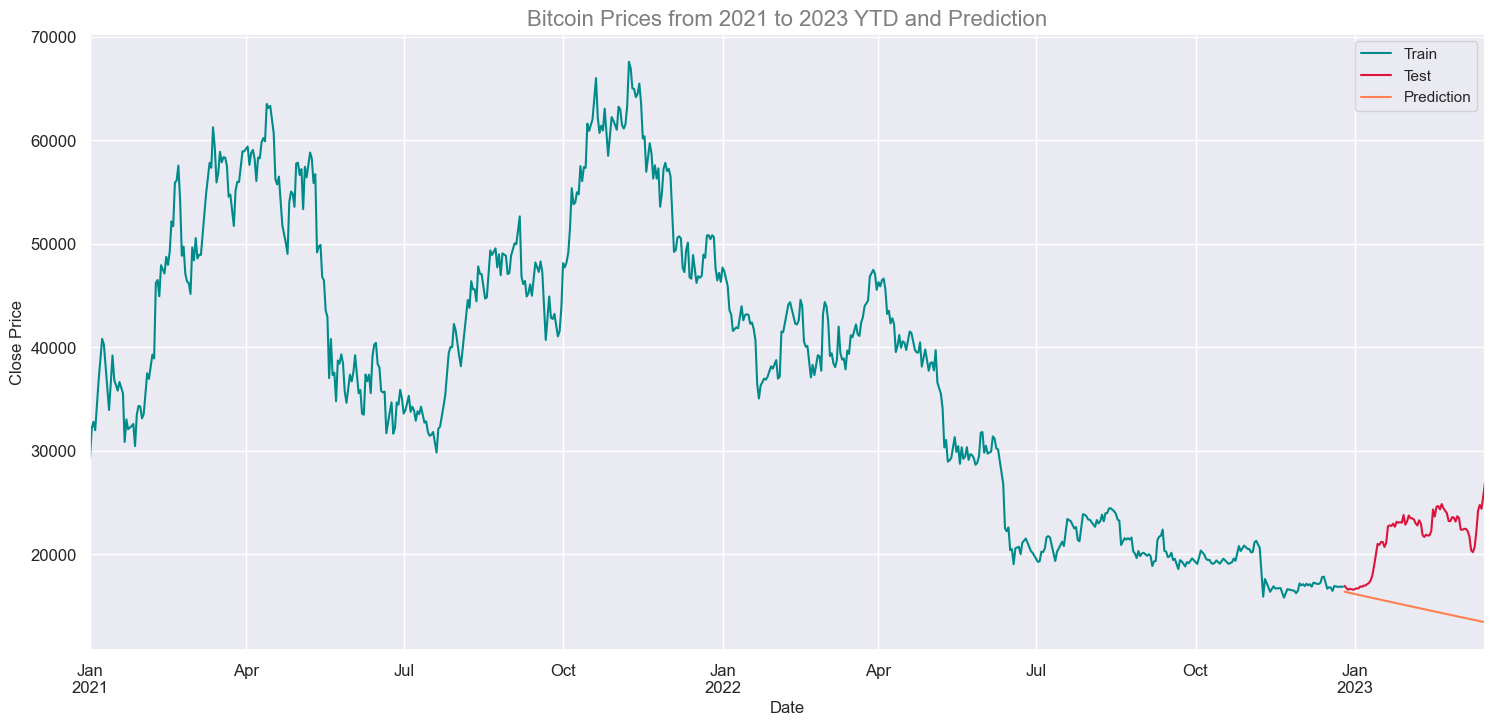

In [25]:
train_graph = train.set_index('date')
test_graph = test.set_index('date')

sns.set_theme()
train_graph.close.plot( figsize=(18,8), fontsize=12, label='Train', color='DarkCyan')
test_graph.close.plot(figsize=(18,8), fontsize=12, label='Test', color='Crimson')
forecast.close.plot(figsize=(18,8), fontsize=12, label='Prediction', color='Coral')
plt.legend()
plt.title("Bitcoin Prices from 2021 to 2023 YTD and Prediction", fontsize=16, color='Grey')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()